Vinos

In [ ]:
!pip install --upgrade pip
!pip install tensorflow-gpu
!pip install --upgrade grpcio
!pip install tqdm
!pip install bert-for-tf2
!pip install sentencepiece

In [ ]:
!pip install squarify
!pip install colorama

In [3]:
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(font_scale=1.2)
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
import re
import matplotlib.image as image
import matplotlib.colors
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import squarify as sq
from colorama import Fore, Back, Style

In [5]:
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving winemag-data-130k-v2.csv to winemag-data-130k-v2.csv


In [53]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')

In [54]:
del df['Unnamed: 0']

In [55]:
df.head(10)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [56]:
df.shape

(129971, 13)

In [57]:
df.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


In [59]:
#Se observan los duplicados de la categoria Description
df[df.duplicated('description',keep=False)].sort_values('description').head(10)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
67614,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
46540,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
119702,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
72181,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
73731,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie
100745,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie
73730,France,87-89 Barrel sample. Minty aromas give lifted ...,Barrel sample,88,NaN,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Haut-Sarpe 2008 Barrel sample (Saint-...,Bordeaux-style Red Blend,Château Haut-Sarpe
100744,France,87-89 Barrel sample. Minty aromas give lifted ...,Barrel sample,88,NaN,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Haut-Sarpe 2008 Barrel sample (Saint-...,Bordeaux-style Red Blend,Château Haut-Sarpe
73729,France,87-89 Barrel sample. With its lovely fresh fru...,Barrel sample,88,NaN,Bordeaux,Lalande de Pomerol,NaN,Roger Voss,@vossroger,Château Bertineau Saint-Vincent 2008 Barrel sa...,Bordeaux-style Red Blend,Château Bertineau Saint-Vincent
100743,France,87-89 Barrel sample. With its lovely fresh fru...,Barrel sample,88,NaN,Bordeaux,Lalande de Pomerol,NaN,Roger Voss,@vossroger,Château Bertineau Saint-Vincent 2008 Barrel sa...,Bordeaux-style Red Blend,Château Bertineau Saint-Vincent


In [60]:
df.drop_duplicates(('description', 'title'), inplace=True)
df[pd.notnull(df.price)]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


In [61]:
df.shape

(119988, 13)

In [62]:
total_info = df.isnull().sum().sort_values(ascending = False)
percent_missing = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total_info, percent_missing], axis=1, keys=['Total', 'Percent_missing'])
missing_data.style.background_gradient(cmap='seismic')

,Total,Percent_missing
region_2,73219,61.021936
designation,34545,28.790379
taster_twitter_handle,29446,24.540787
taster_name,24917,20.766243
region_1,19560,16.301630
price,8395,6.996533
province,59,0.049172
country,59,0.049172
variety,1,0.000833
winery,0,0.000000


In [63]:
for col in ('region_2', 'designation', 'taster_twitter_handle', 'taster_name', 'region_1'):
    df[col]=df[col].fillna('Unknown')
df['province'] = df['province'].fillna(df['province'].mode())
df['price'] = df['price'].fillna(df['price'].mean())

In [64]:
df.head(10)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.620747,Sicily & Sardinia,Etna,Unknown,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,Unknown,Unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",Unknown,87,14.000000,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Unknown,Alexander Peartree,Unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.000000,Northern Spain,Navarra,Unknown,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.000000,Sicily & Sardinia,Vittoria,Unknown,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,France,This dry and restrained wine offers spice in p...,Unknown,87,24.000000,Alsace,Alsace,Unknown,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.000000,Rheinhessen,Unknown,Unknown,Anna Lee C. Iijima,Unknown,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.000000,Alsace,Alsace,Unknown,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


Visualizando

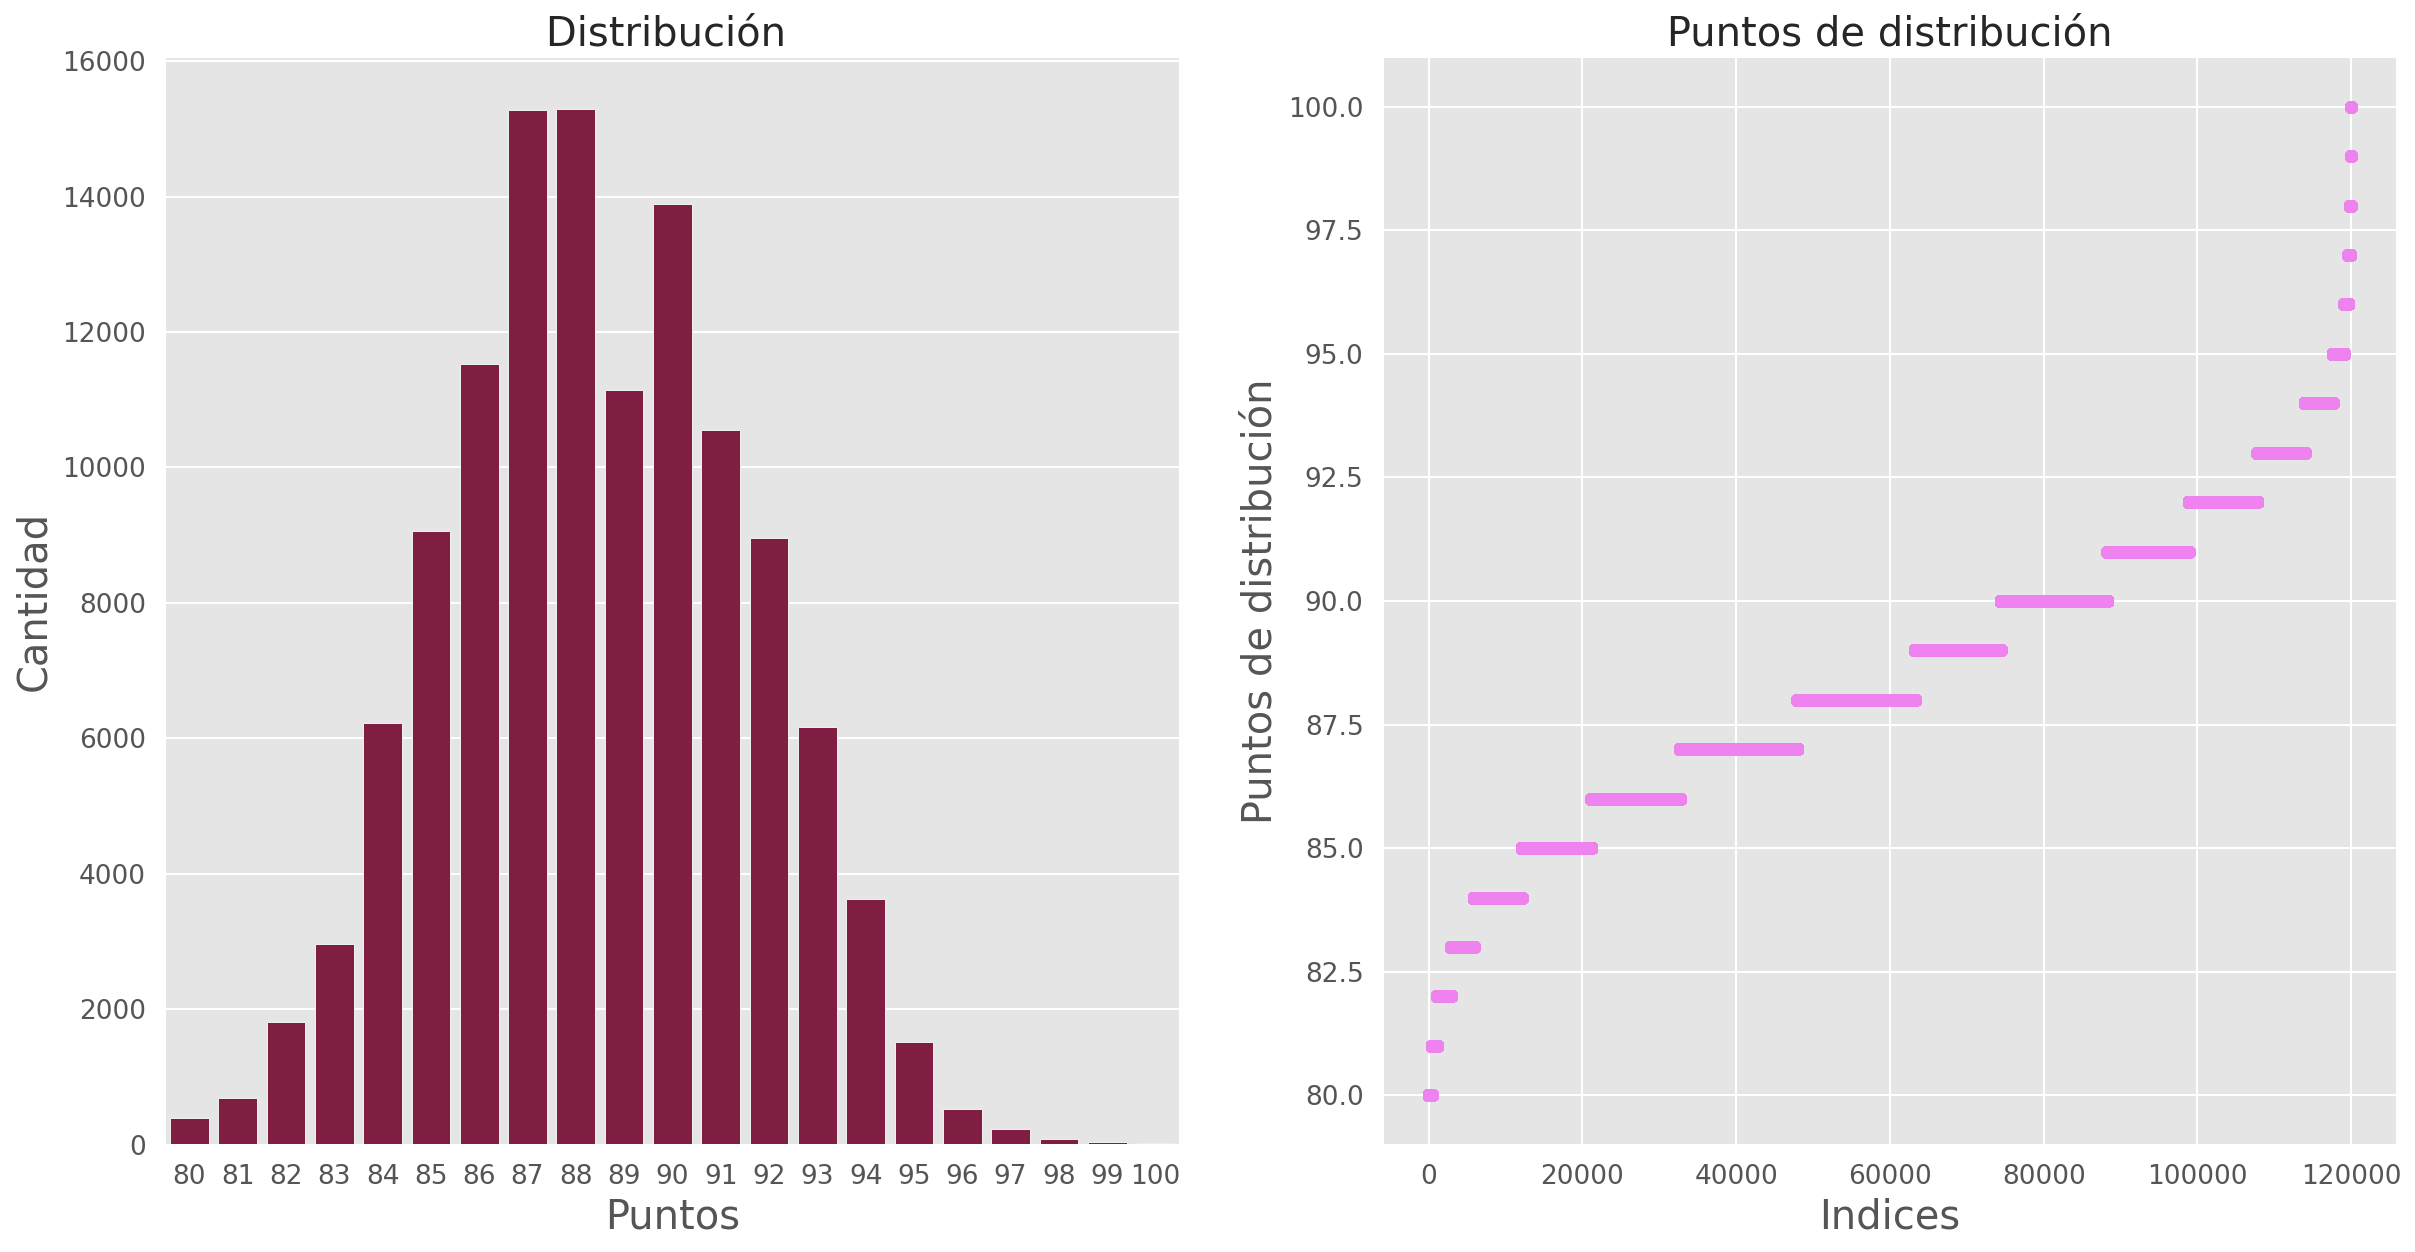

In [65]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1) # Crea una cuadricula de 0.2 x 0.2

g = sns.countplot(x='points', data=df, color='#900C3F') # Se realiza un conteo 
g.set_title("Distribución ", fontsize=20) # tamaño de la fuente y titulo

g.set_xlabel("Puntos", fontsize=20) 
g.set_ylabel("Cantidad", fontsize=20) 


plt.subplot(1,2,2)  # Segundo grafico
plt.scatter(range(df.shape[0]), np.sort(df.points.values), color='violet') # Distribución acumulada
plt.xlabel('Indices', fontsize=20)  
plt.ylabel('Puntos de distribución', fontsize=20)  
plt.title("Puntos de distribución", fontsize=20) 

plt.show() #Graficando

In [66]:
#Definiendo función para outliers
def CantOutlier(df_num): 
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # se define una linea para definir valores altos y bajos
    # este valor es variable
    cut = data_std * 3

    #Calculo de los valores de corte.
    lower, upper = data_mean - cut, data_mean + cut

    # se crea un array con los valores altos, bajos.
    outlier_bajo = [x for x in df_num if x < lower]
    outlier_alto = [x for x in df_num if x > upper]
    outlier_total = [x for x in df_num if x < lower or x > upper]

    # se crea un array sin outliers
    outlier_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Outliers bajos indentificados: %d' % len(outlier_bajo)) 
    print('Outliers altos identificados: %d' % len(outlier_alto)) 
    print('Outliers identificados en ambos extremos: %d' % len(outlier_total))
    print('Cantidad de datos no-Outliers: %d' % len(outlier_removed)) 
    print("Proporción de outliers: ", round((len(outlier_total) / len(outlier_removed) )*100, 4)) 

    return

In [67]:
#Calculando la cantidad de outliers definiendo función
CantOutlier(df['points'])

Outliers bajos indentificados: 0
Outliers altos identificados: 129
Outliers identificados en ambos extremos: 129
Cantidad de datos no-Outliers: 119859
Proporción de outliers:  0.1076


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


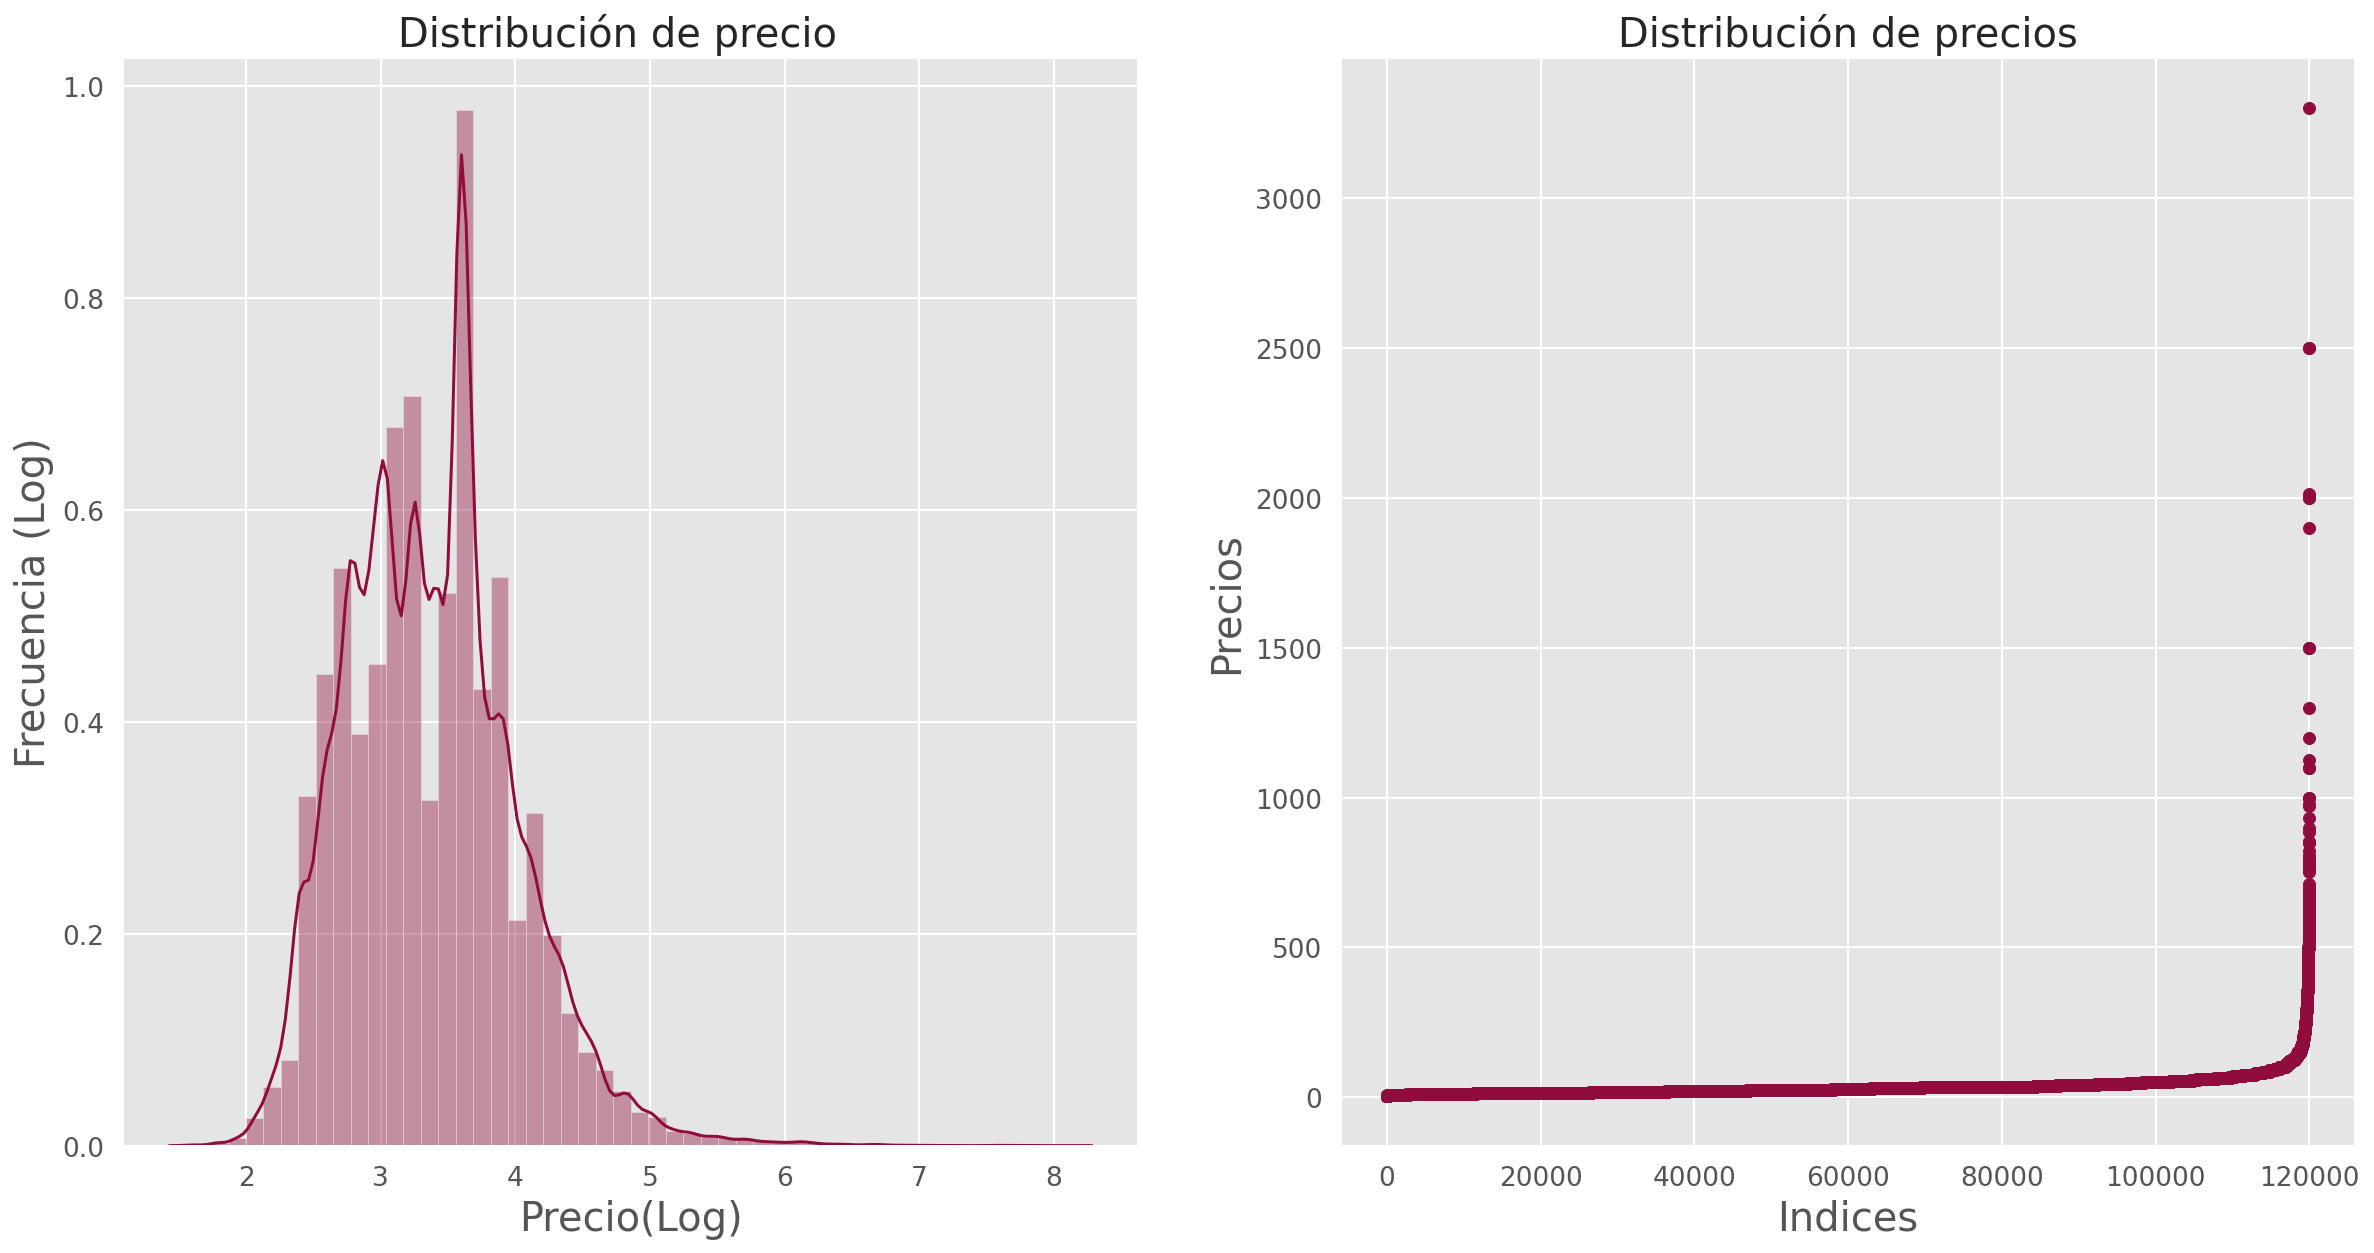

In [68]:
plt.figure(figsize=(20,10))

g1 = plt.subplot(121)
g1 = sns.distplot(np.log(df['price'].dropna() + 1),
                  color='#900C3F')
g1.set_title("Distribución de precio  ", fontsize=20)
g1.set_xlabel("Precio(Log)", fontsize=20)
g1.set_ylabel("Frecuencia (Log)", fontsize=20)

plt.subplot(122)
plt.scatter(range(df.shape[0]), np.sort(df.price.values), 
            color='#900C3F')
plt.xlabel('Indices', fontsize=20)
plt.ylabel('Precios', fontsize=20)
plt.title("Distribución de precios", fontsize=20)


plt.show()

In [69]:
wine_country = df.groupby(['country','points'])['price'].agg(['count','min','max','mean']).sort_values(by='mean',ascending=False)[:10]
wine_country.reset_index(inplace=True)
wine_country.style.background_gradient(cmap='inferno', high=0.5)

,country,points,count,min,max,mean
0,Germany,98,1,775.000000,775.000000,775.000000
1,France,100,8,150.000000,1500.000000,685.375000
2,Australia,99,2,300.000000,850.000000,575.000000
3,Portugal,100,2,450.000000,650.000000,550.000000
4,Spain,98,1,450.000000,450.000000,450.000000
5,Germany,97,8,35.620747,775.000000,411.077593
6,Italy,100,4,210.000000,550.000000,372.500000
7,Australia,100,1,350.000000,350.000000,350.000000
8,Portugal,99,2,268.000000,426.000000,347.000000
9,Italy,99,9,175.000000,595.000000,321.333333


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


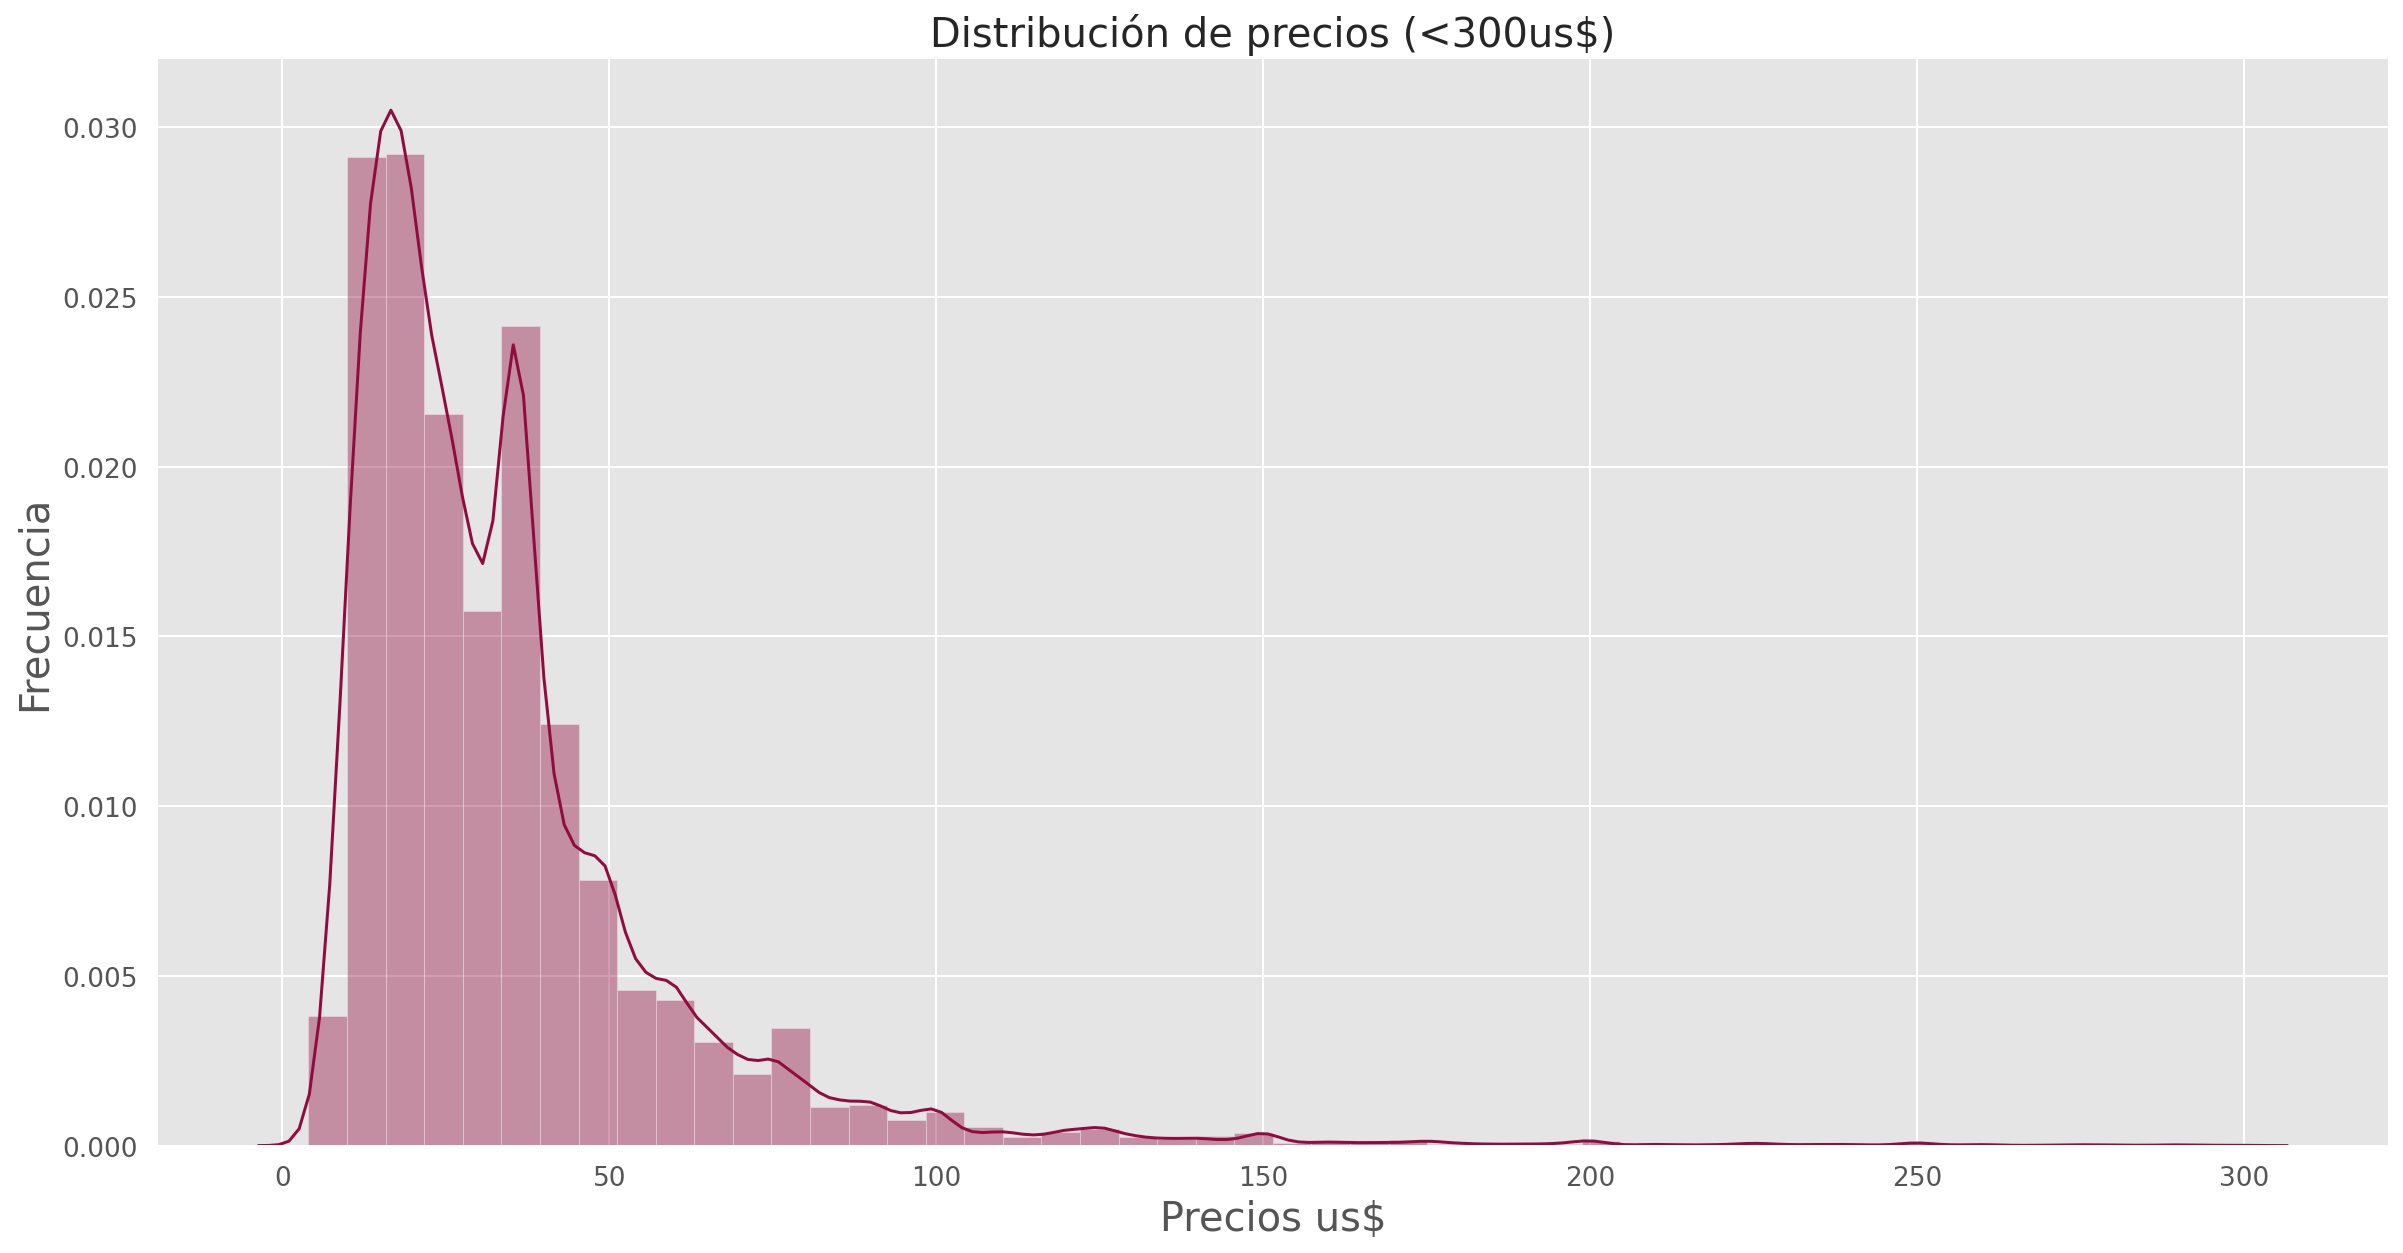

In [70]:
plt.figure(figsize=(20,10))

g = sns.distplot(df[df['price'] < 300]['price'], color='#900C3F')
g.set_title("Distribución de precios (<300us$)", fontsize=20)
g.set_xlabel("Precios us$", fontsize=20)
g.set_ylabel("Frecuencia", fontsize=20)


plt.show()

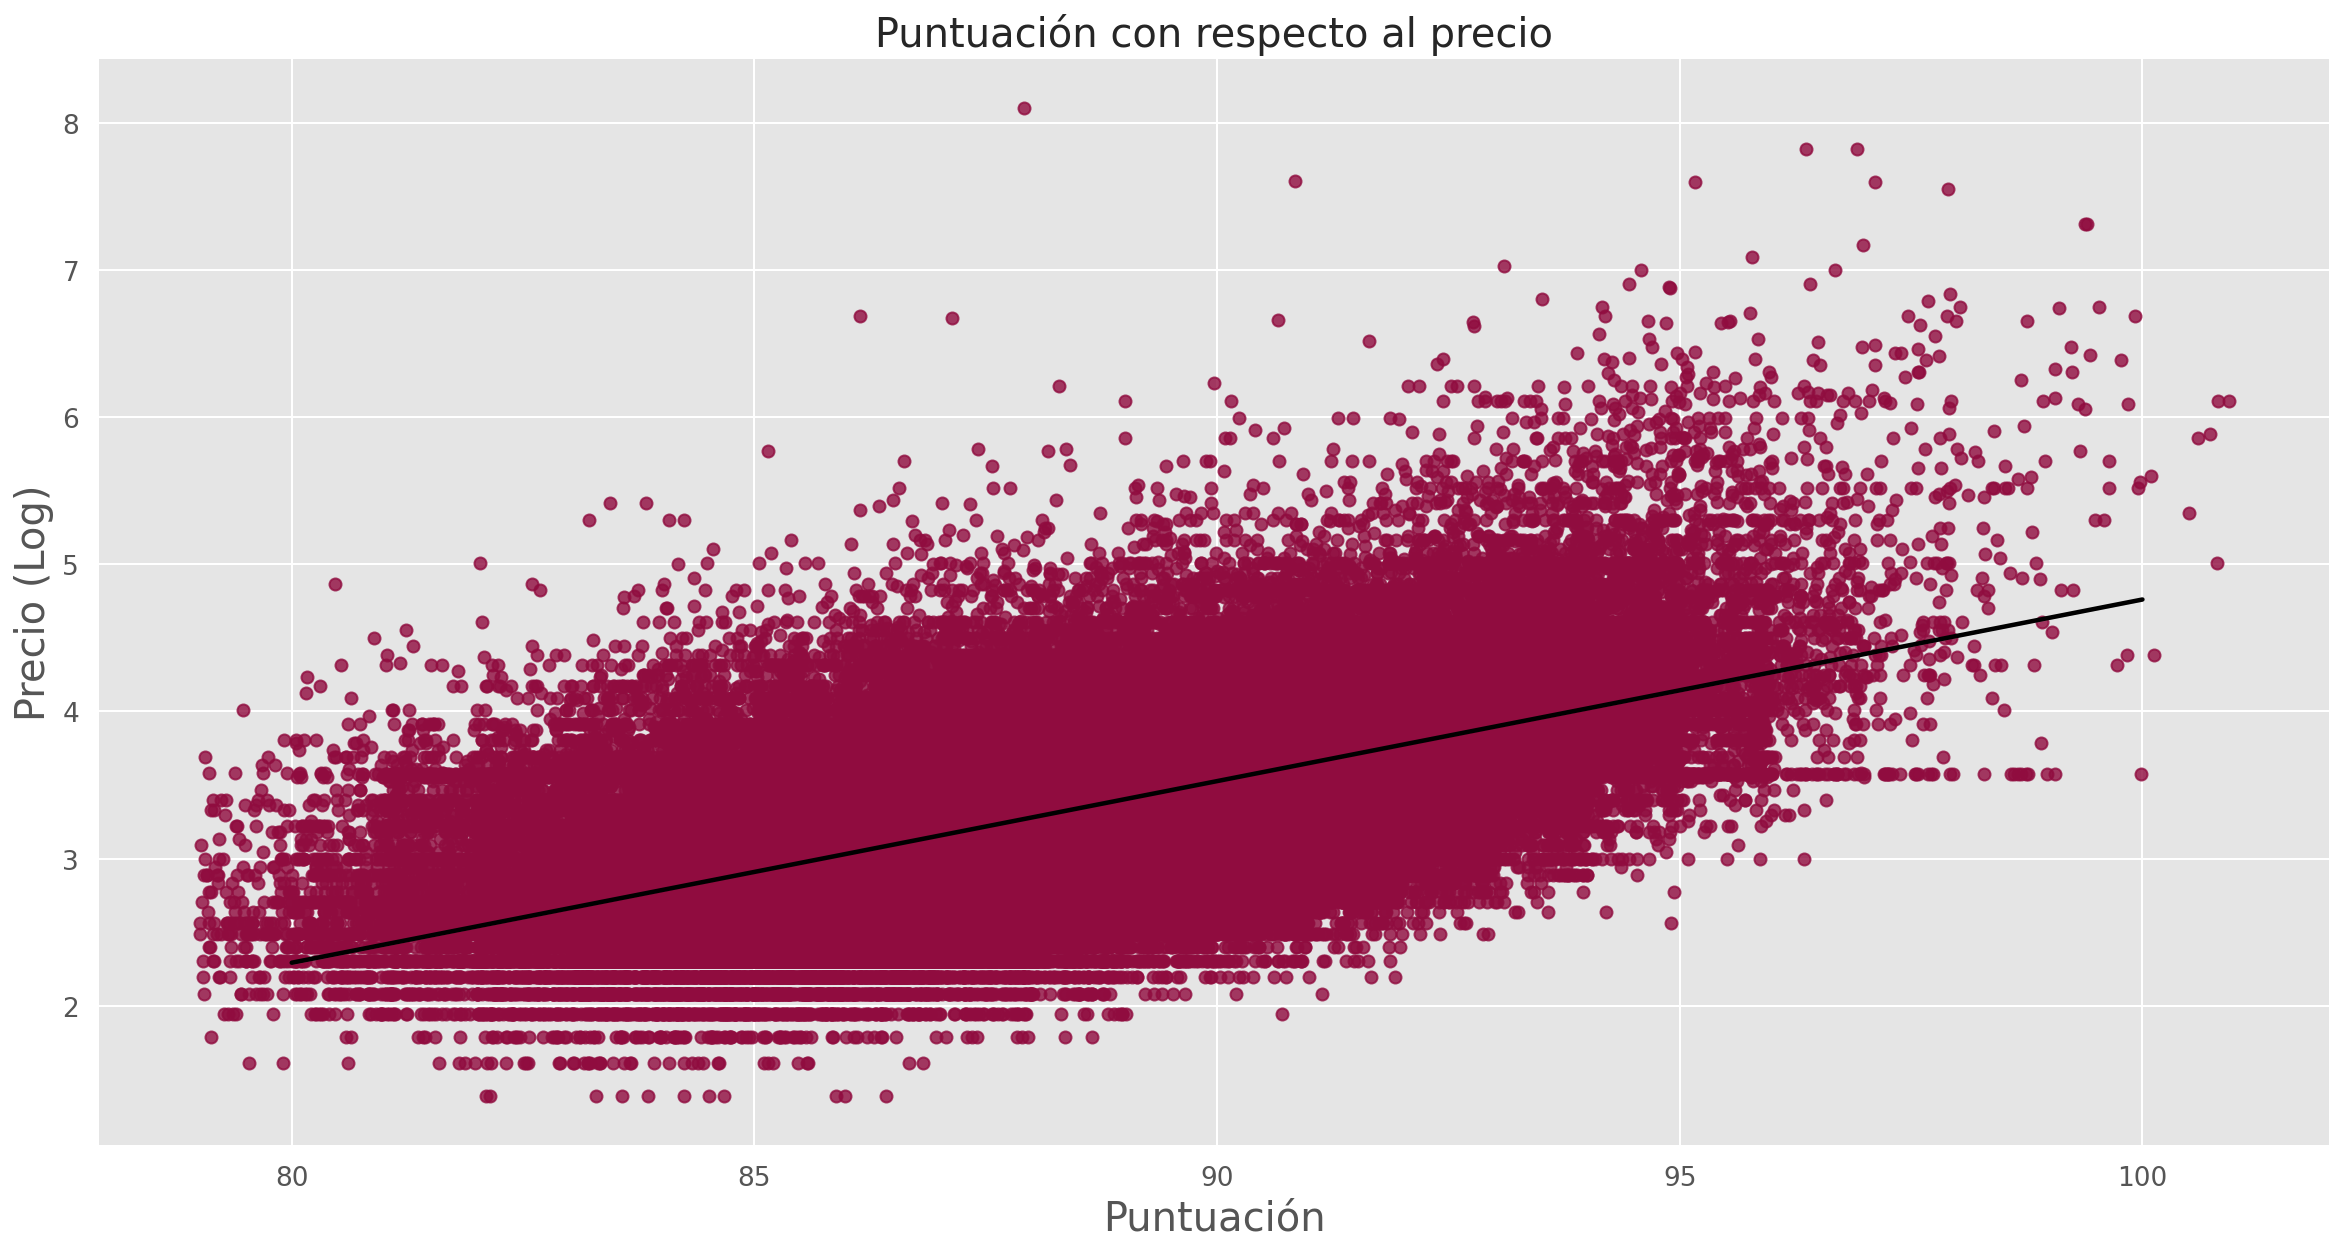

In [71]:
#Se transforma el precio (Log) para trabajar de forma eficiente
df['price_log'] = np.log(df['price'])

plt.figure(figsize=(20,10))

g = sns.regplot(x='points', y='price_log', 
                data=df, line_kws={'color':'black'},
                x_jitter=True, fit_reg=True, color='#900C3F')
g.set_title("Puntuación con respecto al precio", fontsize=20)
g.set_xlabel("Puntuación", fontsize= 20)
g.set_ylabel("Precio (Log)", fontsize= 20)

plt.show()

Variedad de vinos 707


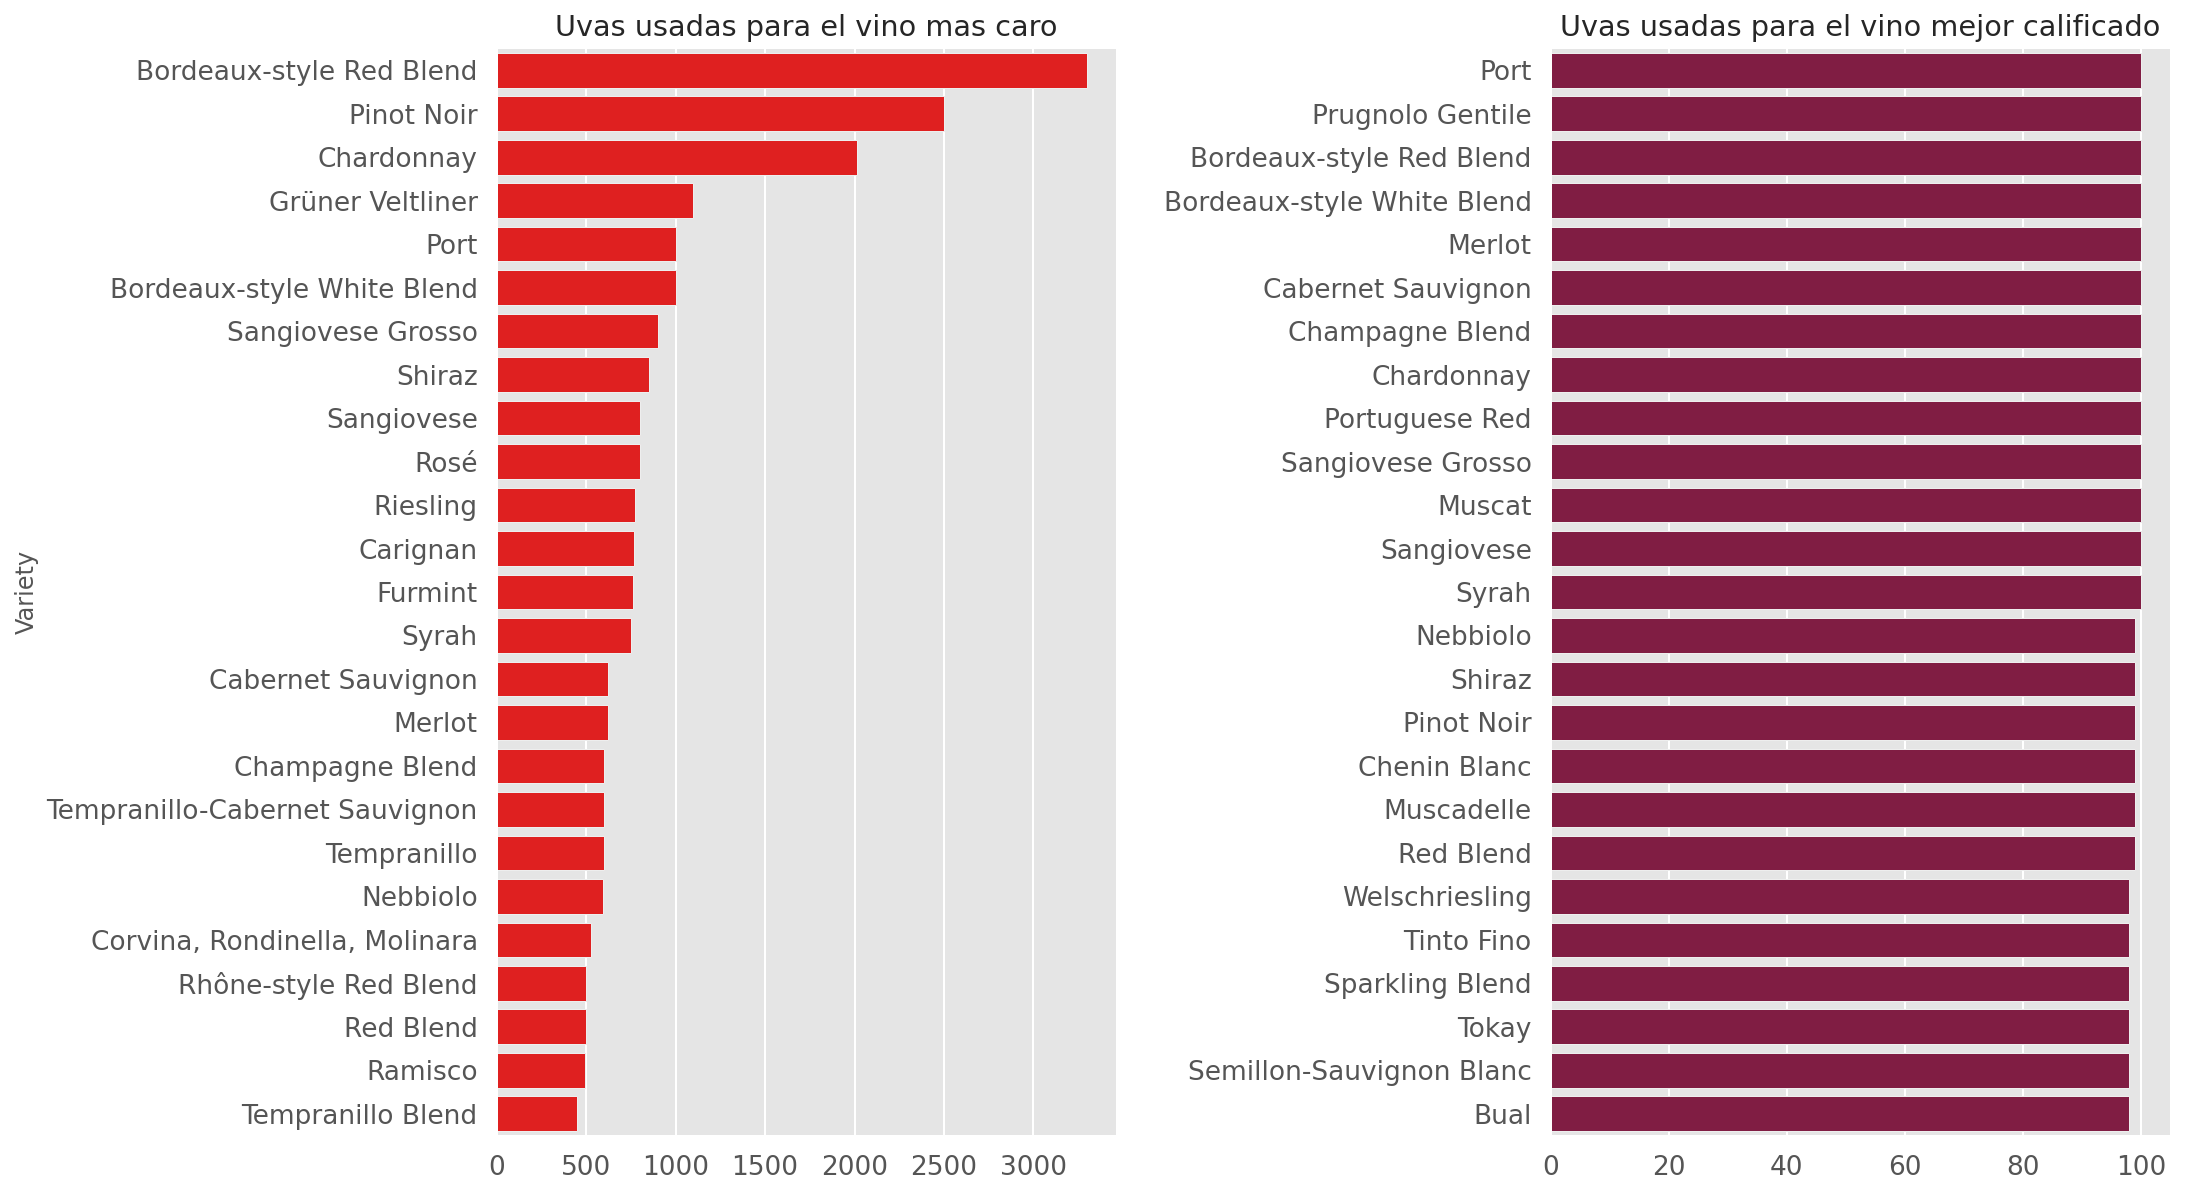

In [81]:
print(Fore.YELLOW + 'Variedad de vinos', df['variety'].nunique())
fig,ax = plt.subplots(1,2,figsize=(15,10))
ax1,ax2 = ax.flatten()
w = df.groupby(['variety'])['price'].max().sort_values(ascending=False).to_frame()[:25]
sns.barplot(x = w['price'], y = w.index, color='red',ax=ax1)
ax1.set_title('Uvas usadas para el vino mas caro')
ax1.set_ylabel('Variety')
ax1.set_xlabel('')
w = df.groupby(['variety'])['points'].max().sort_values(ascending=False).to_frame()[:25]
sns.barplot(x = w['points'], y = w.index, color='#900C3F',ax=ax2)
ax2.set_title('Uvas usadas para el vino mejor calificado')
ax2.set_ylabel('')
ax2.set_xlabel('')
plt.subplots_adjust(wspace=0.7);

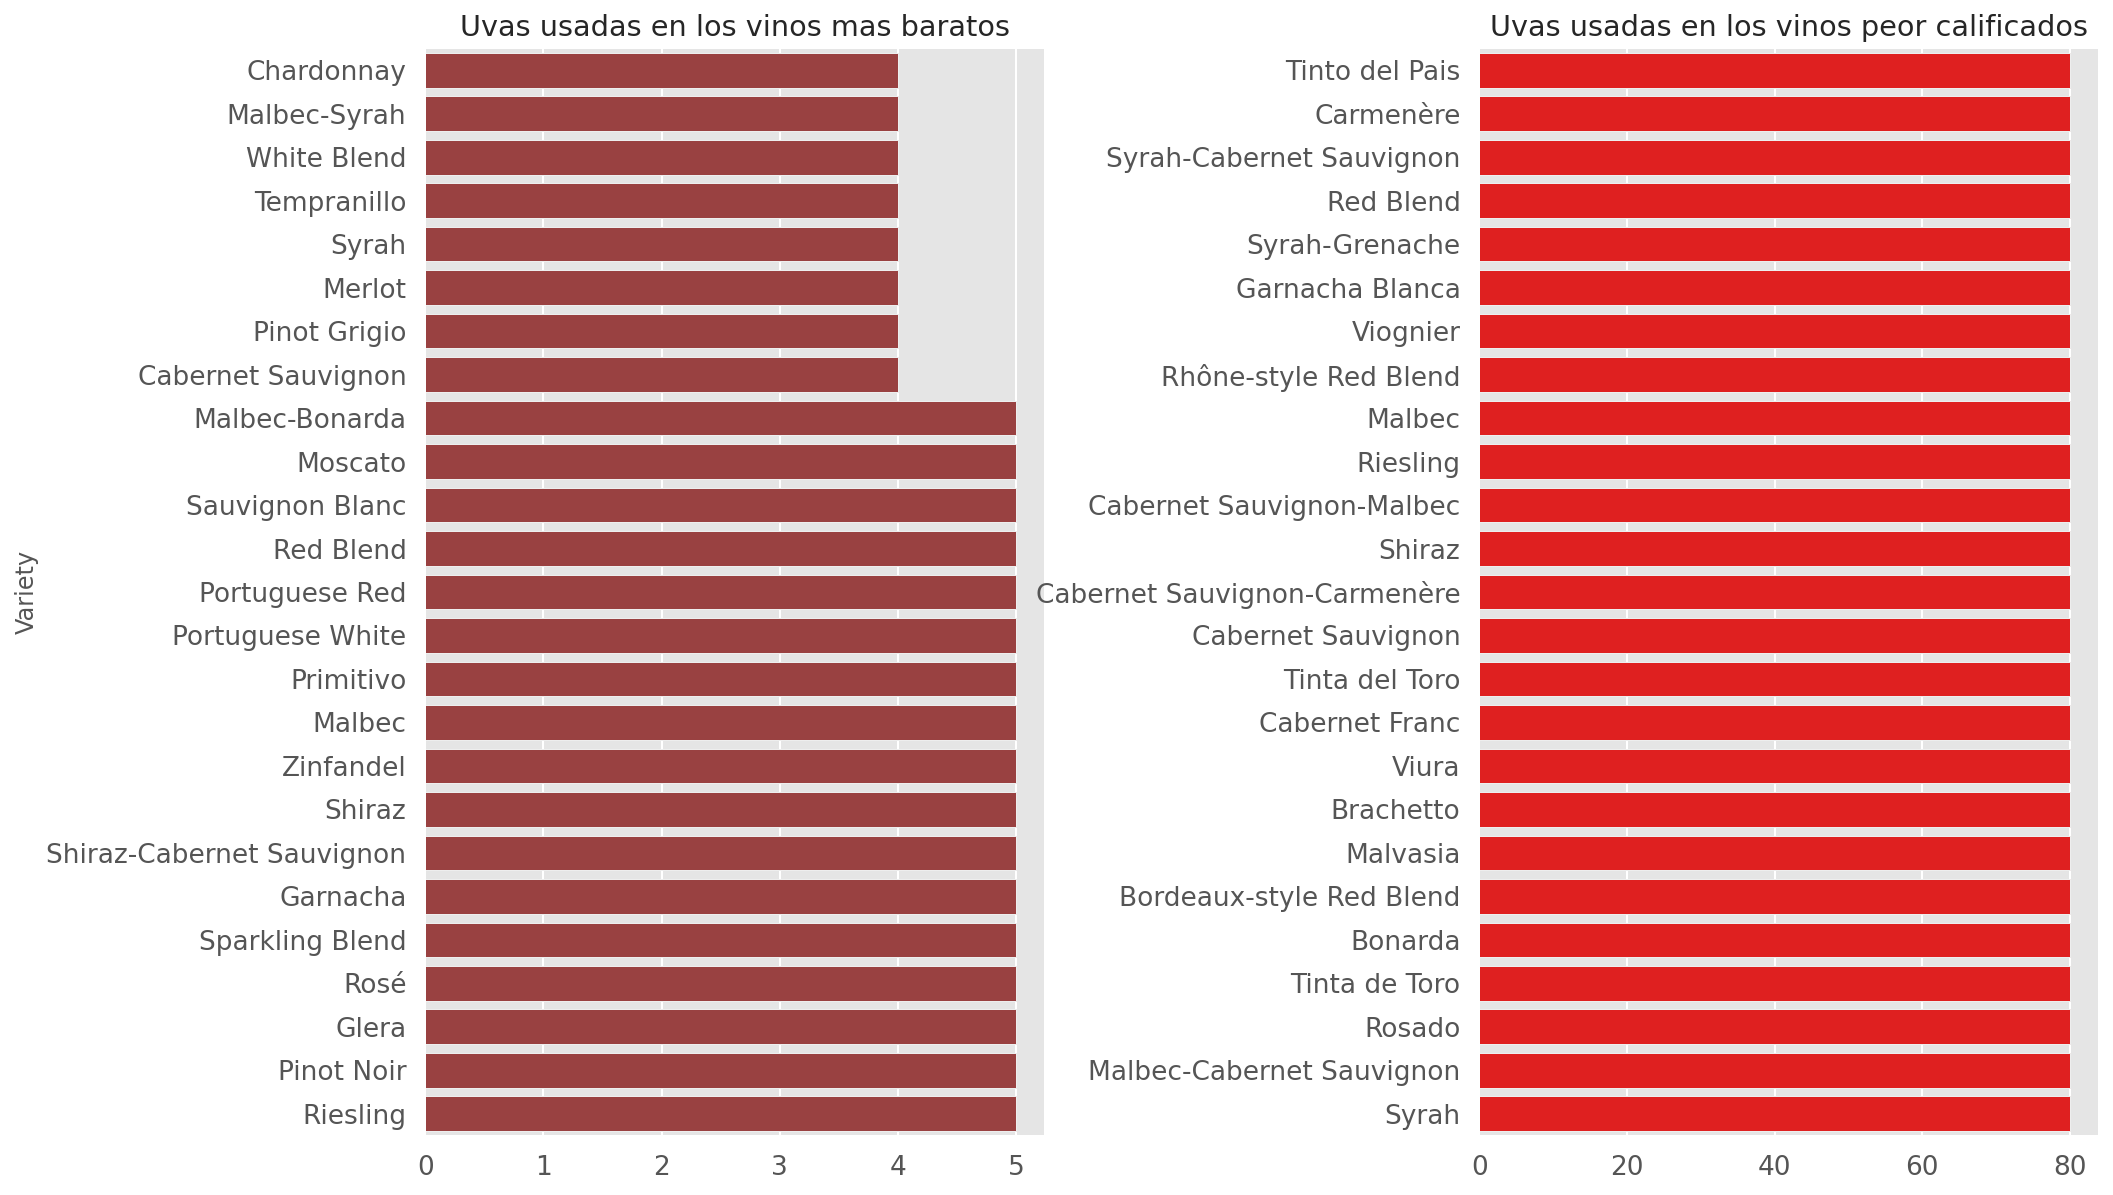

In [82]:
fig,ax = plt.subplots(1,2,figsize=(15,10))
ax1,ax2 = ax.flatten()
w = df.groupby(['variety'])['price'].min().sort_values(ascending=True).to_frame()[:25]
sns.barplot(x = w['price'], y = w.index, color='#a83232',ax=ax1)
ax1.set_title('Uvas usadas en los vinos mas baratos')
ax1.set_xlabel('')
ax1.set_ylabel('Variety')
w = df.groupby(['variety'])['points'].min().sort_values(ascending=True).to_frame()[:25]
sns.barplot(x = w['points'], y = w.index, color='red', ax=ax2)
ax2.set_title('Uvas usadas en los vinos peor calificados')
ax2.set_xlabel('')
ax2.set_ylabel('')
plt.subplots_adjust(wspace=0.7);

In [88]:
df.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery', 'price_log'],
      dtype='object')

Vinos mas caros preparados en viñedos 37980


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


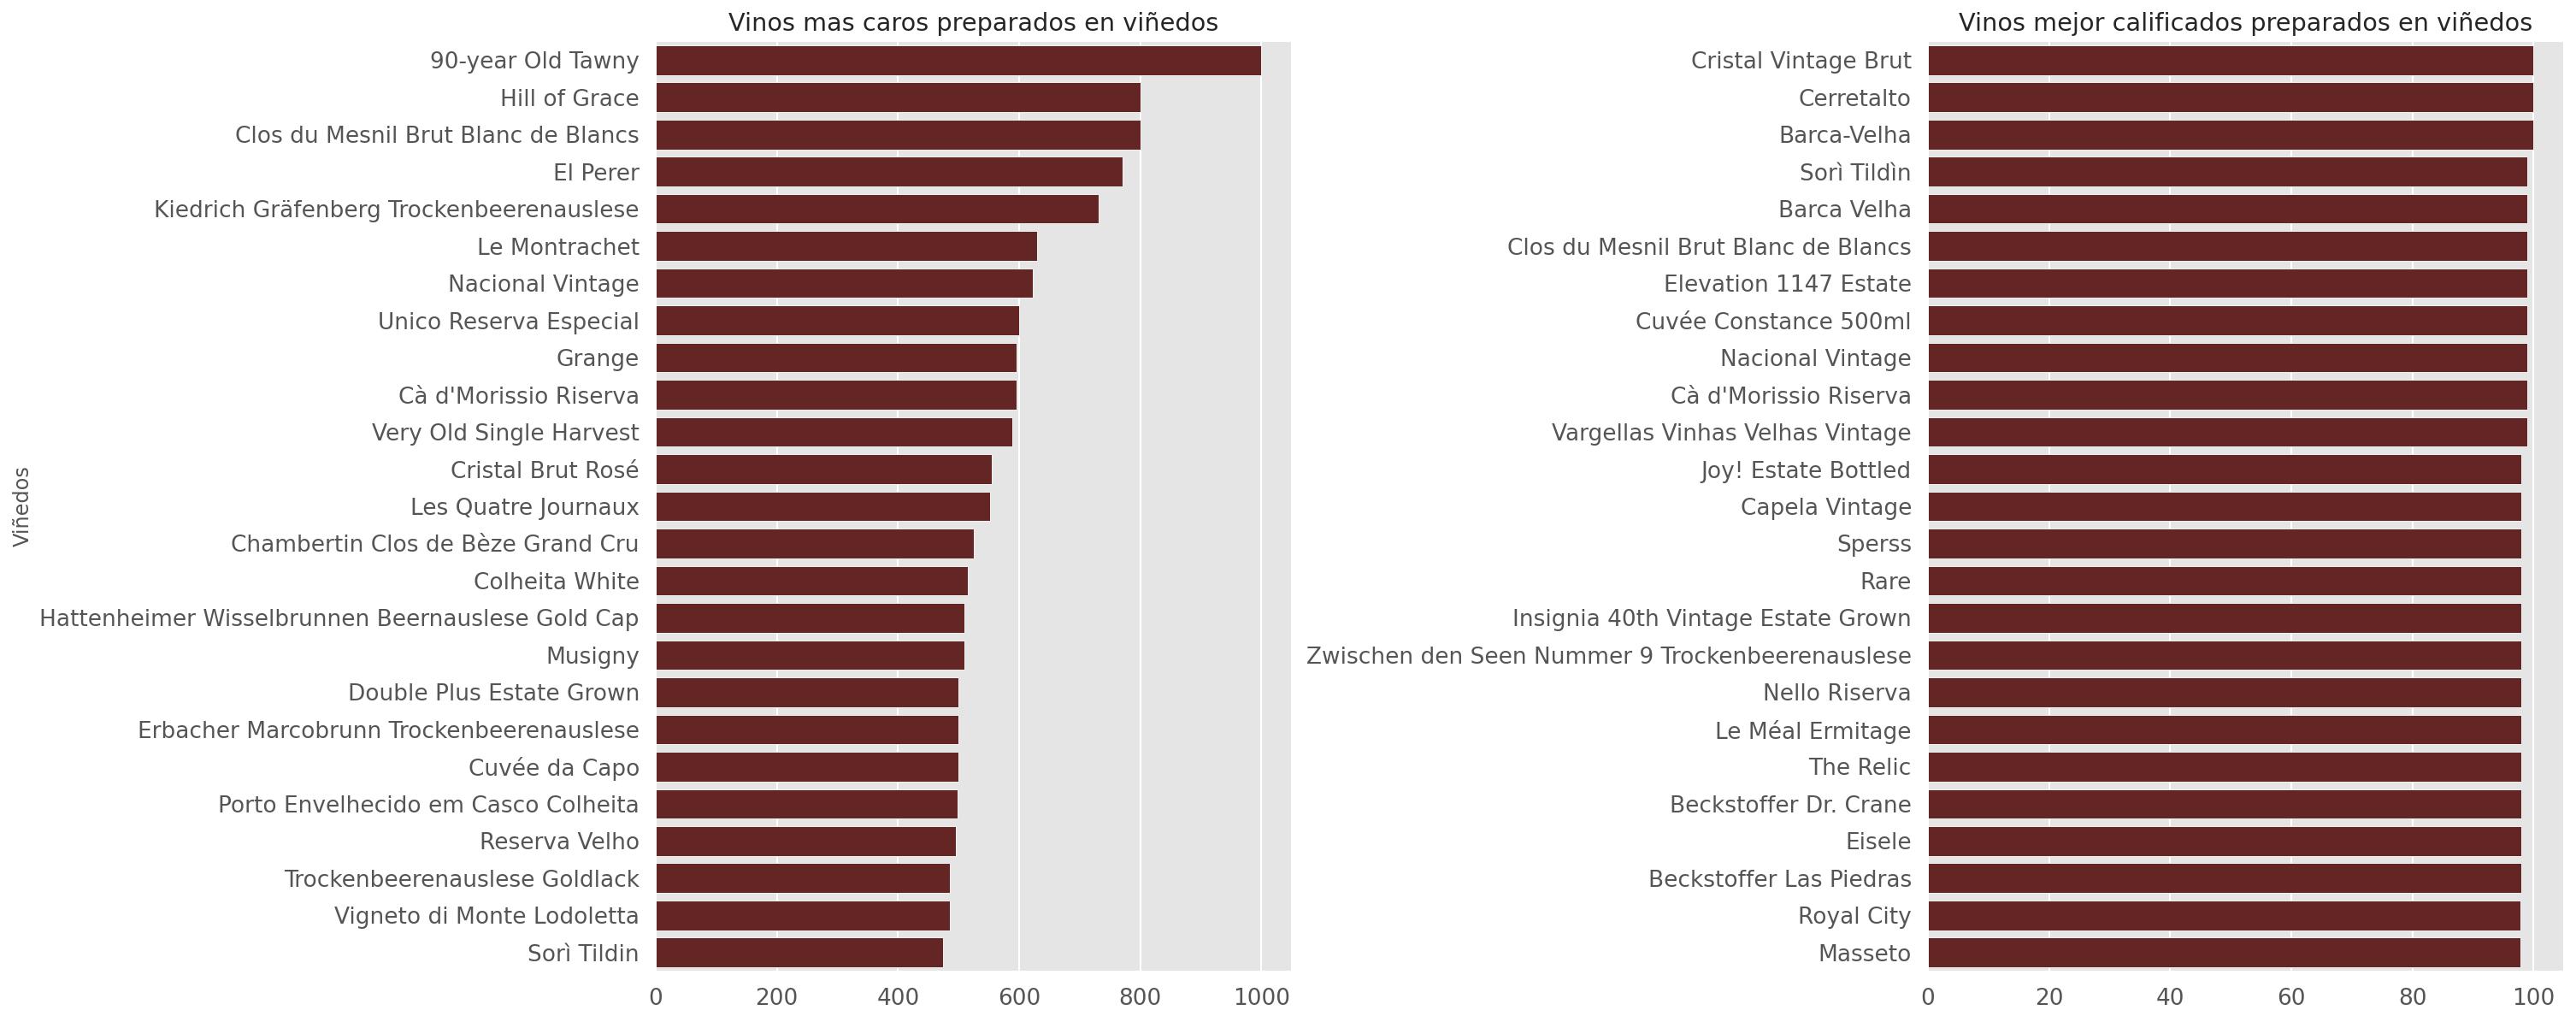

In [87]:
print(Fore.RED + Style.BRIGHT + 'Vinos mas caros preparados en viñedos', df['designation'].nunique())
w = df.groupby(['designation'])['price'].mean().to_frame().sort_values(by='price',ascending=False)[:25]
f,ax = plt.subplots(1,2,figsize= (20,10))
ax1,ax2 = ax.flatten()
sns.barplot(w['price'], y = w.index, color='#6e1b1b', ax = ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Viñedos')
ax1.set_title('Vinos mas caros preparados en viñedos')
w = df.groupby(['designation'])['points'].mean().to_frame().sort_values(by = 'points', ascending = False)[:25]
sns.barplot(w['points'], y = w.index, color='#6e1b1b', ax = ax2)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Vinos mejor calificados preparados en viñedos')
plt.subplots_adjust(wspace=1)

Numero de vinotecas: 16757


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


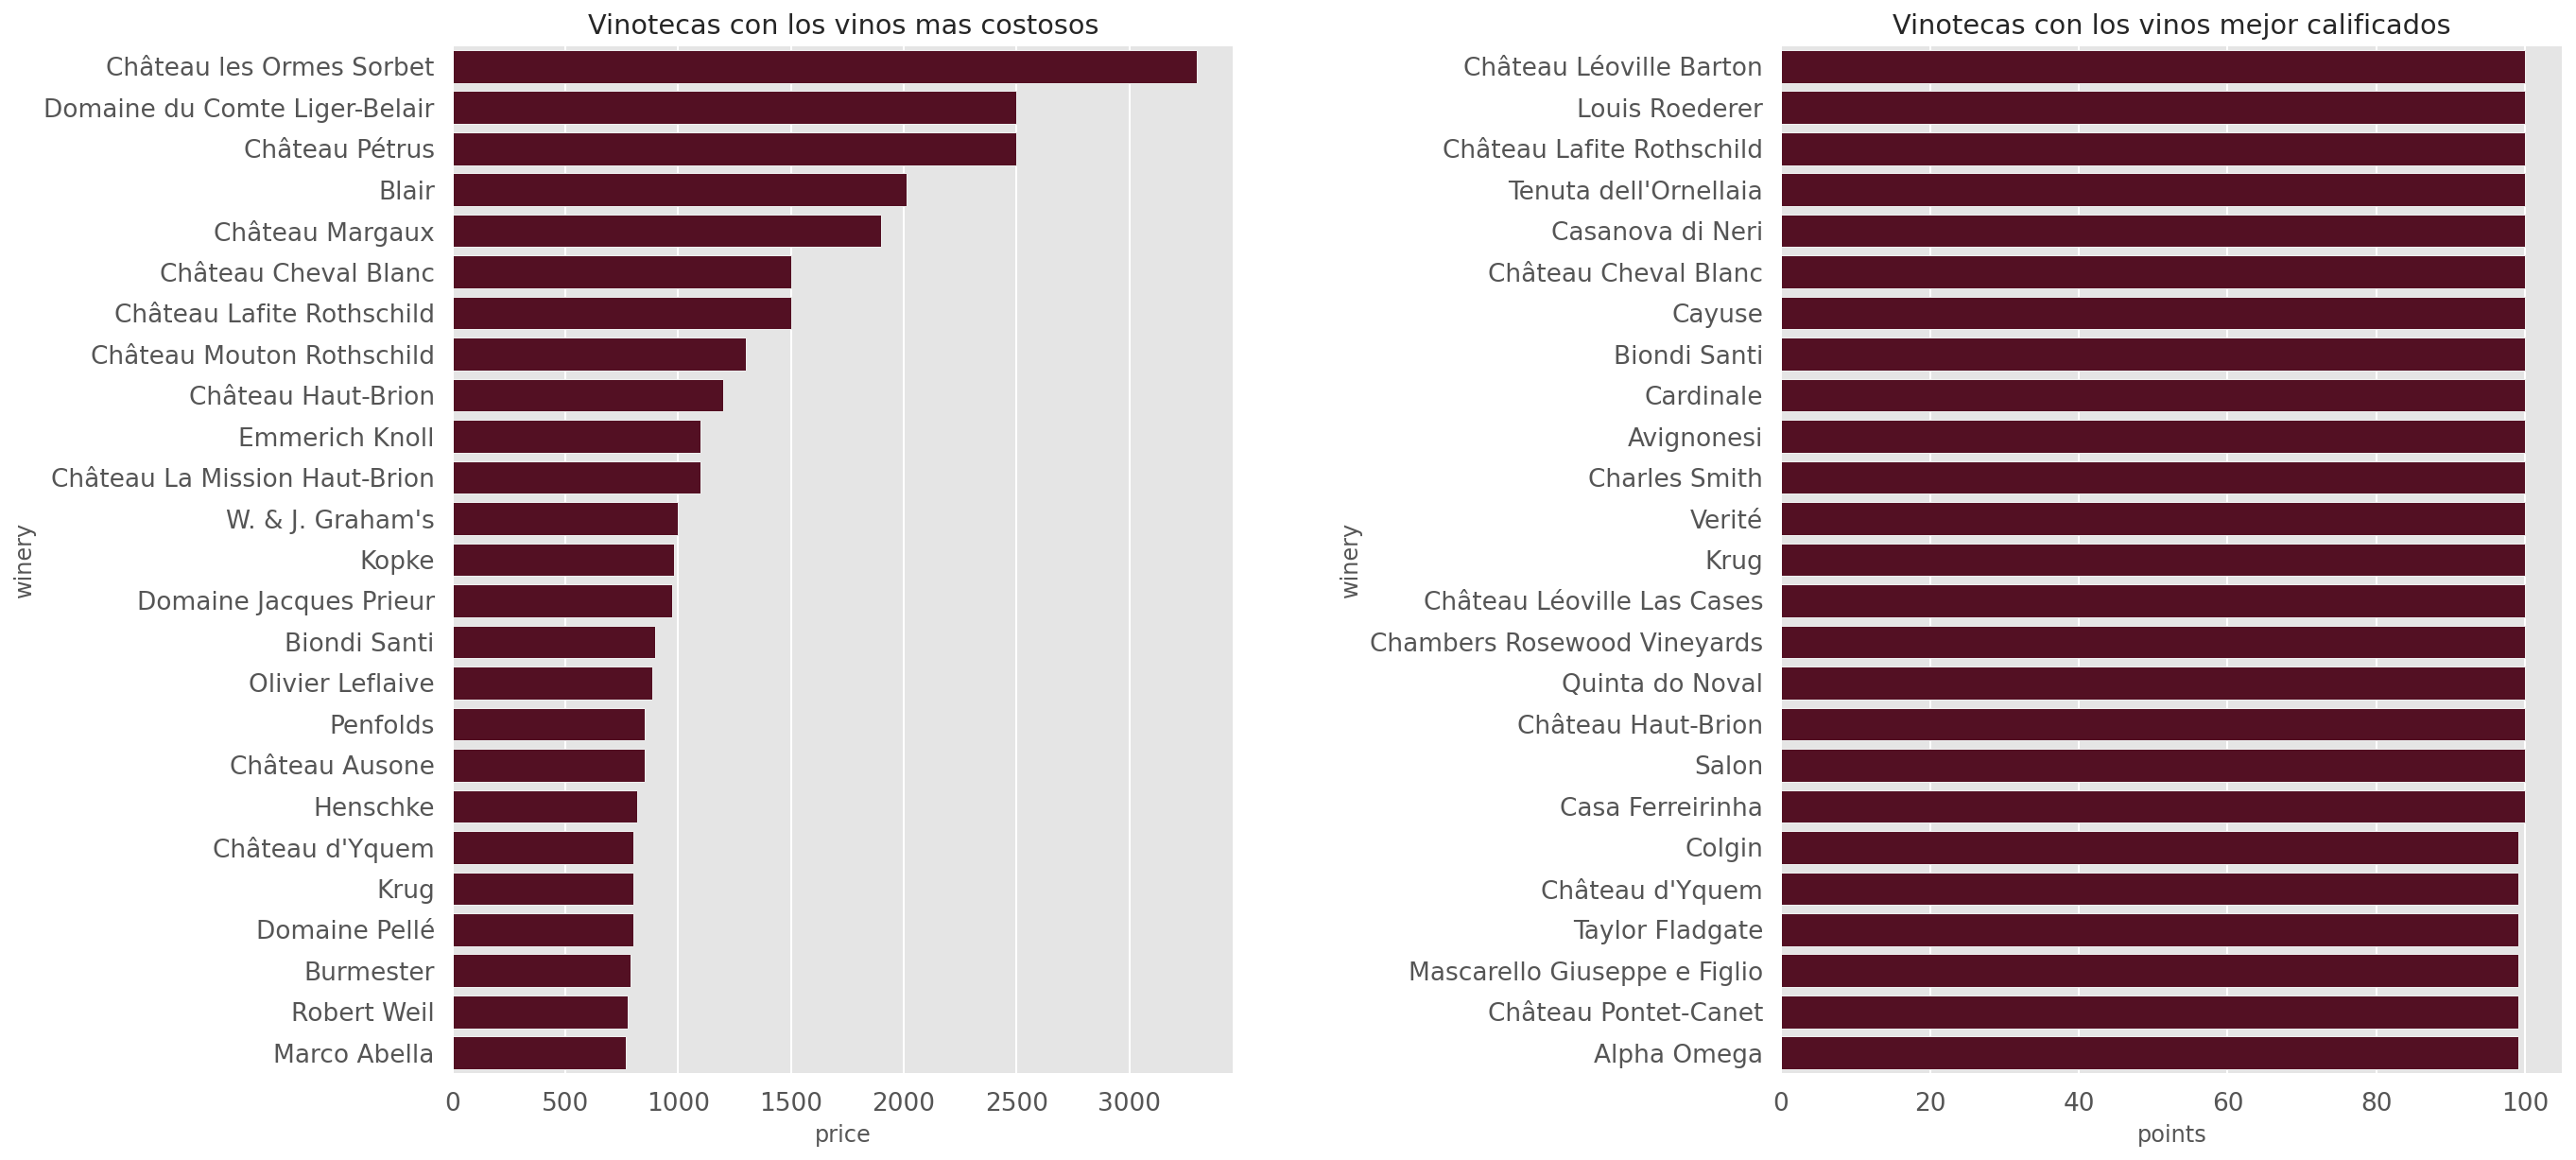

In [92]:
print(Fore.RED + Style.BRIGHT + 'Numero de vinotecas:', df['winery'].nunique())
f,ax = plt.subplots(1,2,figsize=(20,10))
ax1,ax2 = ax.flatten()
w = df.groupby(['winery'])['price'].max().to_frame().sort_values(by='price',ascending=False)[:25]
sns.barplot(w['price'],y = w.index, color='#5e051e',ax = ax1)
ax1.set_title('Vinotecas con los vinos mas costosos')
w = df.groupby(['winery'])['points'].max().to_frame().sort_values(by = 'points', ascending = False)[:25]
sns.barplot(w['points'], y = w.index, color='#5e051e')
plt.title('Vinotecas con los vinos mejor calificados');
plt.subplots_adjust(wspace=0.7)

In [ ]:
!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt

In [34]:
countries = df.country.value_counts()
# Limit top countries to those with more than 500 reviews
temp_dict = countries[countries>500].to_dict()
temp_dict['Other'] = countries[countries<501].sum()
less_countries = pd.Series(temp_dict)
less_countries.sort_values(ascending=False, inplace=True)
# Turn Series into DataFrame for display purposes
df1 = less_countries.to_frame()
df1.columns=['Number of Reviews']
df1.index.name = 'Country'
df1.style.background_gradient(cmap='inferno')

,Number of Reviews
Country,
US,50457
France,20353
Italy,17940
Spain,6116
Portugal,5256
Chile,4184
Argentina,3544
Austria,3034
Other,2277


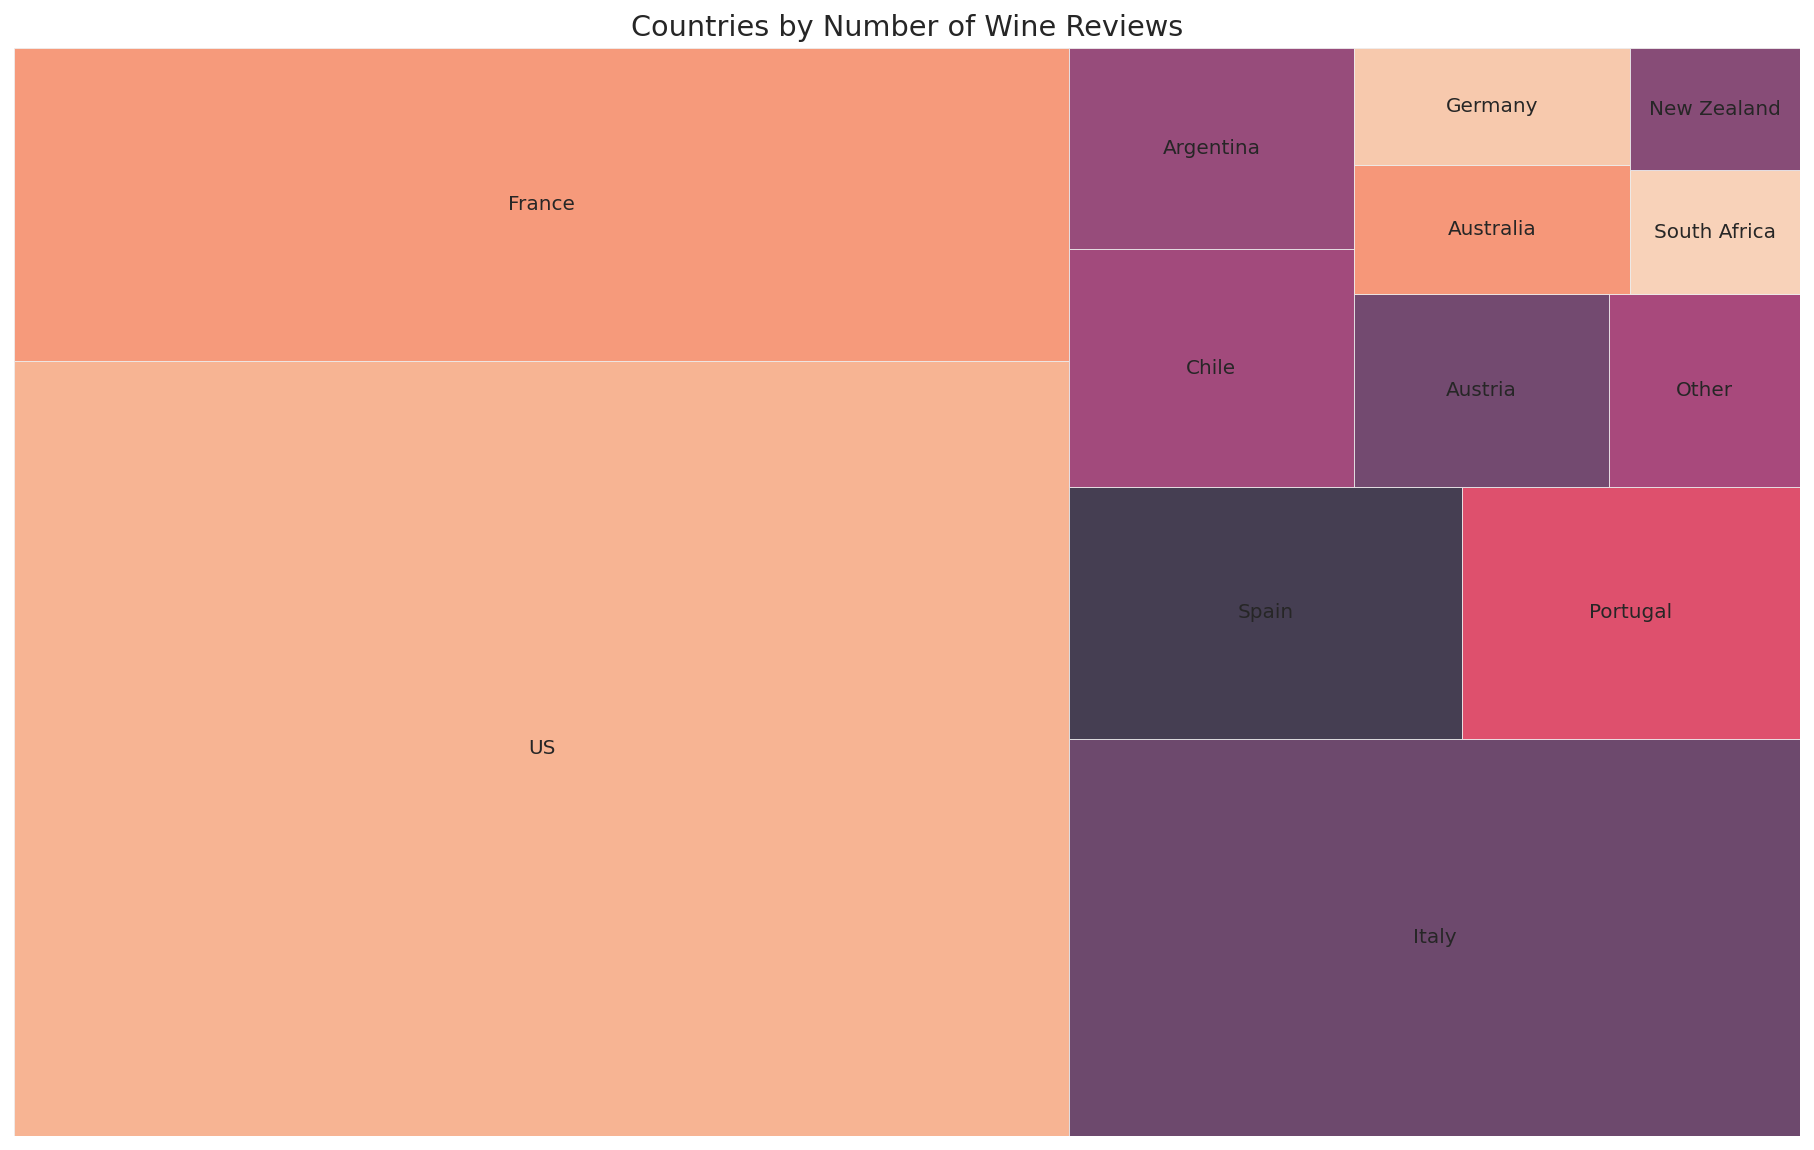

In [49]:
# Tree map 
cmap = plt.cm.gist_rainbow_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=15)
colors = [cmap(norm(value)) for value in range(15)]
np.random.shuffle(colors)
fig,ax = plt.subplots(1,1,figsize=(16, 10))
sq.plot(sizes=less_countries.values, label=less_countries.index.values, alpha=.8, ax=ax)
plt.axis('off')
plt.title('Countries by Number of Wine Reviews')
plt.show()